In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
import h5py


In [2]:
Ls = np.array(
    [
        [8, 32, 32, 32],
        [8, 40, 40, 40],
        [8, 48, 48, 48],
        [8, 56, 56, 56],
        [8, 64, 64, 64],
    ]
)

# Set plotting options
plt.rcParams["font.size"] = "10"
plt.rcParams["figure.figsize"] = (5, 5)
cmap = matplotlib.colormaps["viridis"]
cm_subsection = np.array(np.linspace(0, 200, len(Ls)), dtype=int)
colors = [cmap.colors[x] for x in cm_subsection]
fmt = ["_", "*", "p", "D", "^", "s", "o"]
markersize = 12
capsize = 3

# Number of lattice sites = volume
vol_tot = np.prod(Ls, axis=1, dtype=np.float64)

# spatial volume
vol = np.prod(Ls[:,1:], axis=1, dtype=np.float64)

# Number of Samples
N = 400

bootstrap_seed = 9999

# Reweighting parameters: Set number of bootstraps, reweighting convergence tolerance, reweighting partition and dati header
N_bootstraps = 2000
tol = 1e-14
n_part = 50
dati_head = 5 

# Literature critical beta 6.0625(18)
literature_beta = 6.0625
lit_beta_min = 6.0607
lit_beta_max = 6.0643

In [3]:
os.makedirs(f"../reports/Nt={Ls[0,0]}/figures/", exist_ok=True)

# Reweight observables

In [4]:
###Uncomment following two lines for linux compilation
# %%bash
# python3 setup.py build_ext --inplace

###Uncomment following two lines for cmd compilation
# !python setup.py build_ext --inplace -v

In [5]:
import reweight
print(reweight.__file__)


c:\Users\2237451\OneDrive - Swansea University\Documents\Swansea University\PhD Project\publication\su3_mon\src\reweight.cp310-win_amd64.pyd


In [6]:
os.makedirs(f"../cached_data/", exist_ok=True)

Reweight $\rho_0$

In [7]:
# Reweighting beta values for each lattice size
## to stabilise numerics for smaller lattices sizes
betas_k = [
    np.array(
        [
            6.0545, 6.0565, 6.0585, 6.0625, 6.0645, 6.0665, 6.0700
        ]
    ),
    np.array(
        [
           6.0585, 6.0600, 6.0625, 6.0645, 6.0665, 6.0700,
        ]
    ),
    np.array(
        [
            6.0550, 6.0585, 6.06, 6.0625, 6.0645, 6.0665,
        ]
    ),
    np.array(
        [
            6.061, 6.062, 6.0625, 6.063, 6.0640,
        ]
    ),
    np.array(
        [
            6.0615, 6.0620, 6.0623, 6.0625, 6.0628, 6.0630, 6.0640,
        ]
    ),
]

In [8]:
# Error bars are computed via the bootstrapping method

# Generate bootstraps
np.random.seed(bootstrap_seed)
bootstraps = [
    [
        [
            np.sort(np.random.choice(range(N), size=N, replace=True))
            for i in range(N_bootstraps)
        ]
        for b in range(len(betas_k[l]))
    ]
    for l in range(len(Ls))
]

In [9]:
h = []
for l in range(len(Ls)):
    h_l = []
    for b in betas_k[l]:
        # Load Betti number HDF5 file if exists (else compute and save)
        filename = f"../data/observables/betti/{Ls[l][0]}.{Ls[l][1]}.{Ls[l][2]}.{Ls[l][3]}/betti_NtNsNsNs={Ls[l][0]}{Ls[l][1]}{Ls[l][2]}{Ls[l][3]}_b={b:.4f}.csv"
        # print(filename)
        if os.path.exists(filename):
            h_b = np.loadtxt(filename, delimiter=",", dtype=int)
        h_l.append(h_b)
    h.append(h_l)

In [10]:
# Skip header line + start at sweep 10_000
E_l = []
for l in range(len(Ls)):
    print(Ls[l])
    E_b = []
    for b in range(len(betas_k[l])):
        # print(betas_k[l][b])
        averages = []
        with open(
            f"../data/observables/dati/{Ls[l][0]}.{Ls[l][1]}.{Ls[l][2]}.{Ls[l][3]}/dati.dat{betas_k[l][b]:.4f}",
            "r",
        ) as file:
            for line in file:
                elements = line.split()
                averages.append(
                    1.0 - (0.5 * (np.float64(elements[0]) + np.float64(elements[1])))
                )
        total_action = 6.0 * vol_tot[l] * np.array(averages, dtype=np.float64)
        E_b.append(total_action[dati_head : (dati_head + N)])
    E_l.append(E_b)
E = E_l

[ 8 32 32 32]
[ 8 40 40 40]
[ 8 48 48 48]
[ 8 56 56 56]
[ 8 64 64 64]


In [11]:
# Compute delta_S for use in multiple histogram reweighting
E_bar = [np.mean(E[l], axis=0) for l in range(len(Ls))]
delta_E = [E[l] - E_bar[l][np.newaxis, :] for l in range(len(Ls))]

In [12]:
# Generate b1 bootstrap distribution
b0_bootstrap = [
    [
        np.array([h[l][b][bootstraps[l][b][i]][:, 0] for b in range(len(betas_k[l]))])
        for l in range(len(Ls))
    ]
    for i in range(N_bootstraps)
]

In [13]:
# whole range of betas
rw_betas_linear = [
    np.linspace(betas_k[l][0], betas_k[l][-1], n_part, dtype=np.float64) for l in range(len(Ls))]

In [14]:
rw_means_linear = []
rw_vars_linear = []
rw_means_linear_err = []
rw_vars_linear_err = []
pseudo_bcs_b0_bs = []
for l in range(len(Ls)):
    print(l)
    filename = f"../cached_data/cache_rw_{np.min(rw_betas_linear[l]):.4f}-{np.max(rw_betas_linear[l]):.4f}_NtNsNsNs={Ls[l][0]}{Ls[l][1]}{Ls[l][2]}{Ls[l][3]}_b0.h5"
    if os.path.exists(filename):
        with h5py.File(filename, "r") as hf:
            rw_means_linear.append(hf["rw_means_linear"][()])
            rw_means_linear_err.append(hf["rw_means_linear_err"][()])
            rw_vars_linear.append(hf["rw_vars_linear"][()])
            rw_vars_linear_err.append(hf["rw_vars_linear_err"][()])
            pseudo_bcs_b0_bs.append(hf["pseudo_bc_bs"][()])
    else:
        temp = np.array(h[l])
        rw_means_linear_temp, rw_means_linear_temp_err, rw_vars_linear_temp, rw_vars_linear_temp_err, pseudo_bc_temp_bs = reweight.reweight(
            temp[:, :, 0], delta_E[l], betas_k[l], rw_betas_linear[l], N_bootstraps=N_bootstraps, tol=tol
        )
        with h5py.File(filename, "w") as hf:
            hf.create_dataset("rw_means_linear", data=rw_means_linear_temp)
            hf.create_dataset("rw_means_linear_err", data=rw_means_linear_temp_err)
            hf.create_dataset("rw_vars_linear", data=rw_vars_linear_temp)
            hf.create_dataset("rw_vars_linear_err", data=rw_vars_linear_temp_err)
            hf.create_dataset("pseudo_bc_bs", data=pseudo_bc_temp_bs)
        rw_means_linear.append(rw_means_linear_temp)
        rw_vars_linear.append(rw_vars_linear_temp)
        rw_means_linear_err.append(rw_means_linear_temp_err)
        rw_vars_linear_err.append(rw_vars_linear_temp_err)
        pseudo_bcs_b0_bs.append(pseudo_bc_temp_bs)
rw_means_linear_b0 = np.array(rw_means_linear)
rw_vars_linear_b0 = np.array(rw_vars_linear)
rw_means_linear_err_b0 = np.array(rw_means_linear_err)
rw_vars_linear_err_b0 = np.array(rw_vars_linear_err)
pseudo_bcs_b0_bs = np.array(pseudo_bcs_b0_bs)
rw_means_linear_b0.shape, rw_means_linear_err_b0.shape, rw_vars_linear_b0.shape, rw_vars_linear_err_b0.shape, pseudo_bcs_b0_bs.shape

0
1
2
3
4


((5, 50), (5, 50), (5, 50), (5, 50), (5, 2000))

In [15]:
yerr_b0 = np.std(pseudo_bcs_b0_bs,axis=1)
pseudo_bcs_b0 = np.mean(pseudo_bcs_b0_bs,axis=1)
yerr_b0, pseudo_bcs_b0

(array([0.00287052, 0.00147762, 0.00110022, 0.00047205, 0.00056792]),
 array([6.06537499, 6.06619913, 6.06116811, 6.0627858 , 6.06310497]))

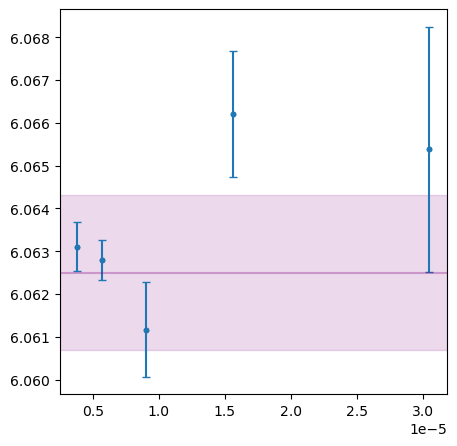

In [16]:
x = 1/vol
y = pseudo_bcs_b0
plt.scatter(x, y, s=10)
plt.errorbar(x, y, yerr=yerr_b0, fmt='.',capsize=3)
plt.axhspan(lit_beta_min, lit_beta_max, color="purple", alpha=0.15)
plt.axhline(literature_beta, color="purple", alpha=0.3)

Reweight $\rho_1$

In [17]:
# Reweighting beta values for each lattice size
## to stabilise numerics for smaller lattices sizes
betas_k = [
    np.array(
        [
            6.0565, 6.0585, 6.0625, 6.0645, 6.0665,
        ]
    ),
    np.array(
        [
            6.055, 6.0585, 6.06, 6.0625, 6.0645
        ]
    ),
    np.array(
        [
            6.06, 6.0625, 6.0645,
        ]
    ),
    np.array(
        [
            6.062, 6.0625, 6.063,
        ]
    ),
    np.array(
        [
            6.0623, 6.0625, 6.0628,
        ]
    ),
]

In [18]:
# Error bars are computed via the bootstrapping method

# Generate bootstraps
np.random.seed(bootstrap_seed)
bootstraps = [
    [
        [
            np.sort(np.random.choice(range(N), size=N, replace=True))
            for i in range(N_bootstraps)
        ]
        for b in range(len(betas_k[l]))
    ]
    for l in range(len(Ls))
]

In [19]:
h = []
for l in range(len(Ls)):
    h_l = []
    for b in betas_k[l]:
        # Load Betti number HDF5 file if exists (else compute and save)
        filename = f"../data/observables/betti/{Ls[l][0]}.{Ls[l][1]}.{Ls[l][2]}.{Ls[l][3]}/betti_NtNsNsNs={Ls[l][0]}{Ls[l][1]}{Ls[l][2]}{Ls[l][3]}_b={b:.4f}.csv"
        # print(filename)
        if os.path.exists(filename):
            h_b = np.loadtxt(filename, delimiter=",", dtype=int)
        h_l.append(h_b)
    h.append(h_l)

In [20]:
# Skip header line + start at sweep 10_000
E_l = []
for l in range(len(Ls)):
    print(Ls[l])
    E_b = []
    for b in range(len(betas_k[l])):
        # print(betas_k[l][b])
        averages = []
        with open(
            f"../data/observables/dati/{Ls[l][0]}.{Ls[l][1]}.{Ls[l][2]}.{Ls[l][3]}/dati.dat{betas_k[l][b]:.4f}",
            "r",
        ) as file:
            for line in file:
                elements = line.split()
                averages.append(
                    1.0 - (0.5 * (np.float64(elements[0]) + np.float64(elements[1])))
                )
        total_action = 6.0 * vol_tot[l] * np.array(averages, dtype=np.float64)
        E_b.append(total_action[dati_head : (dati_head + N)])
    E_l.append(E_b)
E = E_l

[ 8 32 32 32]
[ 8 40 40 40]
[ 8 48 48 48]
[ 8 56 56 56]
[ 8 64 64 64]


In [21]:
# Compute delta_S for use in multiple histogram reweighting
E_bar = [np.mean(E[l], axis=0) for l in range(len(Ls))]
delta_E = [E[l] - E_bar[l][np.newaxis, :] for l in range(len(Ls))]

In [22]:
# Generate b1 bootstrap distribution
b1_bootstrap = [
    [
        np.array([h[l][b][bootstraps[l][b][i]][:, 1] for b in range(len(betas_k[l]))])
        for l in range(len(Ls))
    ]
    for i in range(N_bootstraps)
]

In [23]:
# whole range of betas
rw_betas_linear = [
    np.linspace(betas_k[l][0], betas_k[l][-1], n_part, dtype=np.float64) for l in range(len(Ls))]

In [24]:
rw_means_linear = []
rw_vars_linear = []
rw_means_linear_err = []
rw_vars_linear_err = []
pseudo_bcs_b1_bs = []
for l in range(len(Ls)):
    print(l)
    filename = f"../cached_data/cache_rw_{np.min(rw_betas_linear[l]):.4f}-{np.max(rw_betas_linear[l]):.4f}_NtNsNsNs={Ls[l][0]}{Ls[l][1]}{Ls[l][2]}{Ls[l][3]}_b1.h5"
    if os.path.exists(filename):
        with h5py.File(filename, "r") as hf:
            rw_means_linear.append(hf["rw_means_linear"][()])
            rw_means_linear_err.append(hf["rw_means_linear_err"][()])
            rw_vars_linear.append(hf["rw_vars_linear"][()])
            rw_vars_linear_err.append(hf["rw_vars_linear_err"][()])
            pseudo_bcs_b1_bs.append(hf["pseudo_bc_bs"][()])
    else:
        temp = np.array(h[l])
        rw_means_linear_temp, rw_means_linear_temp_err, rw_vars_linear_temp, rw_vars_linear_temp_err, pseudo_bc_temp_bs = reweight.reweight(
            temp[:, :, 1], delta_E[l], betas_k[l], rw_betas_linear[l], N_bootstraps=N_bootstraps, tol=tol
        )
        with h5py.File(filename, "w") as hf:
            hf.create_dataset("rw_means_linear", data=rw_means_linear_temp)
            hf.create_dataset("rw_means_linear_err", data=rw_means_linear_temp_err)
            hf.create_dataset("rw_vars_linear", data=rw_vars_linear_temp)
            hf.create_dataset("rw_vars_linear_err", data=rw_vars_linear_temp_err)
            hf.create_dataset("pseudo_bc_bs", data=pseudo_bc_temp_bs)
        rw_means_linear.append(rw_means_linear_temp)
        rw_vars_linear.append(rw_vars_linear_temp)
        rw_means_linear_err.append(rw_means_linear_temp_err)
        rw_vars_linear_err.append(rw_vars_linear_temp_err)
        pseudo_bcs_b1_bs.append(pseudo_bc_temp_bs)
rw_means_linear_b1 = np.array(rw_means_linear)
rw_vars_linear_b1 = np.array(rw_vars_linear)
rw_means_linear_err_b1 = np.array(rw_means_linear_err)
rw_vars_linear_err_b1 = np.array(rw_vars_linear_err)
pseudo_bcs_b1_bs = np.array(pseudo_bcs_b1_bs)
rw_means_linear_b1.shape, rw_means_linear_err_b1.shape, rw_vars_linear_b1.shape, rw_vars_linear_err_b1.shape, pseudo_bcs_b1_bs.shape

0
1
2
3
4


((5, 50), (5, 50), (5, 50), (5, 50), (5, 2000))

In [25]:
yerr_b1 = np.std(pseudo_bcs_b1_bs,axis=1)
pseudo_bcs_b1 = np.mean(pseudo_bcs_b1_bs,axis=1)
yerr_b1, pseudo_bcs_b1

(array([0.00110541, 0.00041496, 0.00059189, 0.00031373, 0.00018105]),
 array([6.06035204, 6.0608996 , 6.06276052, 6.06222804, 6.06238836]))

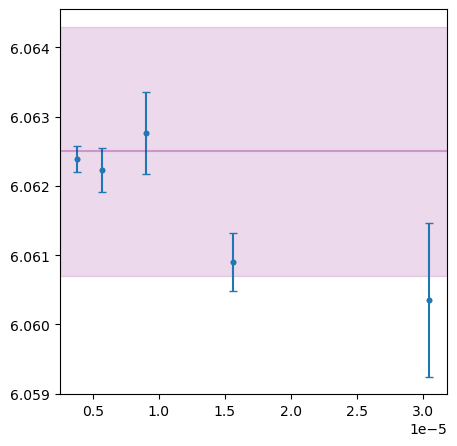

In [26]:
x = 1/vol
y = pseudo_bcs_b1
plt.scatter(x, y, s=10)
plt.errorbar(x, y, yerr=yerr_b1, fmt='.',capsize=3)
plt.axhspan(lit_beta_min, lit_beta_max, color="purple", alpha=0.15)
plt.axhline(literature_beta, color="purple", alpha=0.3)

Reweight $\lambda$

In [27]:
# Reweighting beta values for each lattice size
## to stabilise numerics for smaller lattices sizes
betas_k = [
    np.array(
        [
            6.0545, 6.0565, 6.0585, 6.0625, 6.0645, 6.0665, 6.0700, 6.0750, 6.0800,
        ]
    ),
    np.array(
        [
           6.0550, 6.0585, 6.0600, 6.0625, 6.0645, 6.0665, 6.0700,
        ]
    ),
    np.array(
        [
            6.0600, 6.0625, 6.0645, 6.0665,
        ]
    ),
    np.array(
        [
            6.0610, 6.0620, 6.0625, 6.0630, 6.0640,
        ]
    ),
    np.array(
        [
            6.0615, 6.0620, 6.0623, 6.0625, 6.0628, 6.0630, 6.0640,
        ]
    ),
]

In [28]:
# Error bars are computed via the bootstrapping method

# Generate bootstraps
np.random.seed(bootstrap_seed)
bootstraps = [
    [
        [
            np.sort(np.random.choice(range(N), size=N, replace=True))
            for i in range(N_bootstraps)
        ]
        for b in range(len(betas_k[l]))
    ]
    for l in range(len(Ls))
]

In [29]:
h = []
for l in range(len(Ls)):
    h_l = []
    for b in betas_k[l]:
        # Load Betti number HDF5 file if exists (else compute and save)
        filename = f"../data/observables/betti/{Ls[l][0]}.{Ls[l][1]}.{Ls[l][2]}.{Ls[l][3]}/betti_NtNsNsNs={Ls[l][0]}{Ls[l][1]}{Ls[l][2]}{Ls[l][3]}_b={b:.4f}.csv"
        # print(filename)
        if os.path.exists(filename):
            h_b = np.loadtxt(filename, delimiter=",", dtype=int)
        h_l.append(h_b)
    h.append(h_l)

In [30]:
# Skip header line + start at sweep 10_000
E_l = []
for l in range(len(Ls)):
    print(Ls[l])
    E_b = []
    for b in range(len(betas_k[l])):
        # print(betas_k[l][b])
        averages = []
        with open(
            f"../data/observables/dati/{Ls[l][0]}.{Ls[l][1]}.{Ls[l][2]}.{Ls[l][3]}/dati.dat{betas_k[l][b]:.4f}",
            "r",
        ) as file:
            for line in file:
                elements = line.split()
                averages.append(
                    1.0 - (0.5 * (np.float64(elements[0]) + np.float64(elements[1])))
                )
        total_action = 6.0 * vol_tot[l] * np.array(averages, dtype=np.float64)
        E_b.append(total_action[dati_head : (dati_head + N)])
    E_l.append(E_b)
E = E_l

[ 8 32 32 32]
[ 8 40 40 40]
[ 8 48 48 48]
[ 8 56 56 56]
[ 8 64 64 64]


In [31]:
# Compute delta_S for use in multiple histogram reweighting
E_bar = [np.mean(E[l], axis=0) for l in range(len(Ls))]
delta_E = [E[l] - E_bar[l][np.newaxis, :] for l in range(len(Ls))]

In [32]:
# Generate b1 bootstrap distribution
ratio01_bootstrap = [
    [
        np.array([(h[l][b][bootstraps[l][b][i]][:, 0] / h[l][b][bootstraps[l][b][i]][:, 1]) for b in range(len(betas_k[l]))])
        for l in range(len(Ls))
    ]
    for i in range(N_bootstraps)
]

In [33]:
# whole range of betas
rw_betas_linear = [
    np.linspace(betas_k[l][0], betas_k[l][-1], n_part, dtype=np.float64) for l in range(len(Ls))]

In [34]:
rw_means_linear = []
rw_vars_linear = []
rw_means_linear_err = []
rw_vars_linear_err = []
pseudo_bcs_r01_bs = []
for l in range(len(Ls)):
    print(l)
    filename = f"../cached_data/cache_rw_{np.min(rw_betas_linear[l]):.4f}-{np.max(rw_betas_linear[l]):.4f}_NtNsNsNs={Ls[l][0]}{Ls[l][1]}{Ls[l][2]}{Ls[l][3]}_r01.h5"
    if os.path.exists(filename):
        with h5py.File(filename, "r") as hf:
            rw_means_linear.append(hf["rw_means_linear"][()])
            rw_means_linear_err.append(hf["rw_means_linear_err"][()])
            rw_vars_linear.append(hf["rw_vars_linear"][()])
            rw_vars_linear_err.append(hf["rw_vars_linear_err"][()])
            pseudo_bcs_r01_bs.append(hf["pseudo_bc_bs"][()])
    else:
        temp = np.array(h[l])
        rw_means_linear_temp, rw_means_linear_temp_err, rw_vars_linear_temp, rw_vars_linear_temp_err, pseudo_bc_temp_bs = reweight.reweight(
            (temp[:, :, 0] / temp[:, :, 1]), delta_E[l], betas_k[l], rw_betas_linear[l], N_bootstraps=N_bootstraps, tol=tol
        )
        with h5py.File(filename, "w") as hf:
            hf.create_dataset("rw_means_linear", data=rw_means_linear_temp)
            hf.create_dataset("rw_means_linear_err", data=rw_means_linear_temp_err)
            hf.create_dataset("rw_vars_linear", data=rw_vars_linear_temp)
            hf.create_dataset("rw_vars_linear_err", data=rw_vars_linear_temp_err)
            hf.create_dataset("pseudo_bc_bs", data=pseudo_bc_temp_bs)
        rw_means_linear.append(rw_means_linear_temp)
        rw_vars_linear.append(rw_vars_linear_temp)
        rw_means_linear_err.append(rw_means_linear_temp_err)
        rw_vars_linear_err.append(rw_vars_linear_temp_err)
        pseudo_bcs_r01_bs.append(pseudo_bc_temp_bs)
rw_means_linear_r01 = np.array(rw_means_linear)
rw_vars_linear_r01 = np.array(rw_vars_linear)
rw_means_linear_err_r01 = np.array(rw_means_linear_err)
rw_vars_linear_err_r01 = np.array(rw_vars_linear_err)
pseudo_bcs_r01_bs = np.array(pseudo_bcs_r01_bs)
rw_means_linear_r01.shape, rw_means_linear_err_r01.shape, rw_vars_linear_r01.shape, rw_vars_linear_err_r01.shape, pseudo_bcs_r01_bs.shape

0
1
2
3
4


((5, 50), (5, 50), (5, 50), (5, 50), (5, 2000))

In [35]:
yerr_r01 = np.std(pseudo_bcs_r01_bs,axis=1)
pseudo_bcs_r01 = np.mean(pseudo_bcs_r01_bs,axis=1)
yerr_r01, pseudo_bcs_r01

(array([0.00144808, 0.00102656, 0.00068113, 0.00037126, 0.00046525]),
 array([6.0615177 , 6.06304138, 6.06355066, 6.06252247, 6.06264191]))

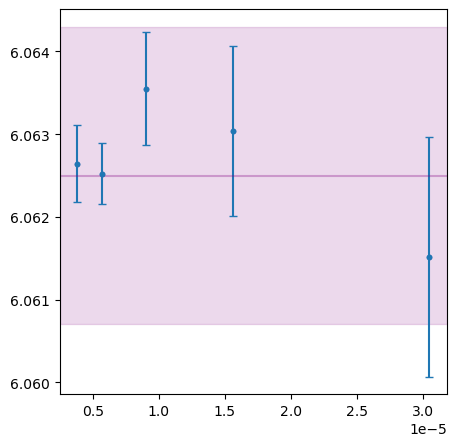

In [36]:
x = 1/vol
y = pseudo_bcs_r01
plt.scatter(x, y, s=10)
plt.errorbar(x, y, yerr=yerr_r01, fmt='.',capsize=3)
plt.axhspan(lit_beta_min, lit_beta_max, color="purple", alpha=0.15)
plt.axhline(literature_beta, color="purple", alpha=0.3)

# Finite-size scaling analysis

In [37]:
import polars as pl
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from scipy.optimize import brentq

In [38]:
def format_NIST(m, u):
    """Formats measurement and standard error in NIST:
    https://physics.nist.gov/cgi-bin/cuu/Info/Constants/definitions.html
    """
    m = float(m)
    u = float(u)
    u_order = int(np.floor(np.log10(u)))
    round_m = "{:.{}f}".format(m, -1 * u_order)
    round_u = str(int(np.round(u * 10 ** (-u_order))))
    return round_m + "(" + round_u + ")"


In [39]:
def fss(type, Ls_for_reg, deg, y, y_bs):
    """Function to output range, k_max, reduced_chi2, AIC, beta_c, beta_c_err.
       Returns None if an unacceptable fit (with internal extremum) is detected.
    """
    # Perform polynomial regression
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly_features.fit_transform(x.reshape(-1, 1))
    lin_reg = LinearRegression().fit(X_poly[Ls_for_reg], y[Ls_for_reg])

    if deg >= 2:
        # Descending order: [a_d, ..., a_1, a_0]
        p_coefs_desc = list(lin_reg.coef_[::-1]) + [lin_reg.intercept_]
        der_coefs = np.polyder(p_coefs_desc)
        roots = np.roots(der_coefs)
        real_roots = roots[np.isreal(roots)].real
        x_min = 0.0
        x_max = x.max()
        # Check if any real root is strictly inside the data range
        if np.any((real_roots > x_min) & (real_roots < x_max)):
            print("Rejecting fit; found internal extremum at", real_roots)
            return None

    # Compute intercept error via bootstrap
    intercepts = [
        LinearRegression().fit(X_poly[Ls_for_reg], y_bs[i][Ls_for_reg]).intercept_
        for i in range(N_bootstraps)
    ]
    intercept_err = np.sqrt(np.var(intercepts))

    # Compute reduced chi-squared
    f_obs = y[Ls_for_reg]
    f_exp = lin_reg.predict(X_poly[Ls_for_reg])
    var = np.var(y_bs[:, Ls_for_reg], axis=0)
    chi2 = np.sum((f_obs - f_exp) ** 2 / var)

    # Calculate AIC
    n_par = deg + 1
    n_data = len(Ls_for_reg)
    aic_unnorm = np.exp(-0.5 * (chi2 + 2 * n_par - n_data))

    return (
        type,
        str(Ls[Ls_for_reg][0]),
        str(Ls[Ls_for_reg][-1]),
        deg,
        chi2,
        aic_unnorm,
        lin_reg.intercept_,
        list(lin_reg.coef_),
        intercept_err,
        f"{chi2:.3f}",
        f"{aic_unnorm:.3f}",
        format_NIST(lin_reg.intercept_, intercept_err),
    )


In [40]:
# Define the mixture CDF: sum_i w_i * N(x|mu_i, sigma_i)
def mixture_cdf(x, weights, means, sigmas):
    return np.sum(weights * norm.cdf(x, loc=means, scale=sigmas))

# Function to find x such that the CDF equals a target value.
def find_quantile(target, weights, means, sigmas, x_min, x_max):
    func = lambda x: mixture_cdf(x, weights, means, sigmas) - target
    return brentq(func, x_min, x_max)

In [41]:
def format_asymmetric_error(lower, central, upper):
    """
    Given lower (X_16), central (X_50), and upper (X_84) values as floats,
    compute asymmetric uncertainties, round them to appropriate significant figures,
    and return a LaTeX-formatted string.
    """
    # Compute the deltas
    delta_minus = central - lower
    delta_plus = upper - central

    def round_uncertainty(d):
        """Round uncertainty to 1 significant figure, or 2 if first digit is 1."""
        if d == 0:
            return 0.0, 0
        exp = np.floor(np.log10(d))
        first_digit = d / (10 ** exp)
        sig_figs = 2 if 1 <= first_digit < 2 else 1
        # Number of decimal places for round()
        decimals = max(0, int(-exp + (sig_figs - 1)))
        return round(d, decimals), decimals

    rm, dec_m = round_uncertainty(delta_minus)
    rp, dec_p = round_uncertainty(delta_plus)
    # Decimal places for central value
    dec_c = max(dec_m, dec_p)
    central_rounded = round(central, dec_c)

    # Build the LaTeX string
    fmt = f"${central_rounded:.{dec_c}f}" \
          f"^{{+{rp:.{dec_c}f}}}_{{-{rm:.{dec_c}f}}}$"
          
    return fmt

$\rho_0$

In [42]:
# Define the range of Ls values to be used in FSS
range_ = [[2, 3, 4], [1, 2, 3, 4], [0, 1, 2, 3, 4]]

# When computing results, filter out any models where fss returns None
results = []
for type, ps_bc, ps_bc_var in [("rho_b0", pseudo_bcs_b0, pseudo_bcs_b0_bs.T)]:
    for i in range(len(range_)):
        for d in range(1, len(range_[i]) - 1):
            model = fss(type, range_[i], d, ps_bc, ps_bc_var)
            if model is not None:
                results.append(model)

Rejecting fit; found internal extremum at [8.45957164e-06]
Rejecting fit; found internal extremum at [2.76432842e-05]
Rejecting fit; found internal extremum at [2.40481719e-05 7.77396436e-06]


In [43]:
df = pl.DataFrame(results)
df.columns = [
    "observable",
    "range_min",
    "range_max",
    "k_max",
    "chi2",
    "aic_unnorm",
    "beta_c",
    "coefficients",
    "beta_c_err",
    "str_chi2",
    "str_aic",
    "beta_c_NIST",
]

In [44]:
df

observable,range_min,range_max,k_max,chi2,aic_unnorm,beta_c,coefficients,beta_c_err,str_chi2,str_aic,beta_c_NIST
str,str,str,i64,f64,f64,f64,list[f64],f64,str,str,str
"""rho_b0""","""[ 8 48 48 48]""","""[ 8 64 64 64]""",1,0.352216,0.508593,6.064726,[-383.678639],0.001316,"""0.352""","""0.509""","""6.065(1)"""
"""rho_b0""","""[ 8 40 40 40]""","""[ 8 64 64 64]""",1,8.53116,0.014044,6.061006,[270.218339],0.000897,"""8.531""","""0.014""","""6.0610(9)"""
"""rho_b0""","""[ 8 32 32 32]""","""[ 8 64 64 64]""",1,6.505679,0.063747,6.062118,[124.319371],0.000984,"""6.506""","""0.064""","""6.0621(10)"""


In [45]:
# Extract AIC, intercepts, and errors
weight_unnorms_b0 = np.array([model[5] for model in results])  # Assuming AIC is the 6th element
beta_c_values_b0 = np.array([model[6] for model in results])  # Intercept
beta_c_errs_b0 = np.array([model[8] for model in results])  # Intercept error

# Compute model weights (pr(M|D))
weights_b0 = weight_unnorms_b0 / np.sum(weight_unnorms_b0)
weights_b0

array([0.8673387 , 0.02394974, 0.10871156])

In [46]:
# Define a search interval that should comfortably include the distribution.
x_min_search = np.min(beta_c_values_b0) - 5 * np.max(beta_c_errs_b0)
x_max_search = np.max(beta_c_values_b0) + 5 * np.max(beta_c_errs_b0)

# Compute the quantiles for the median and the 68% interval.
lower_val = find_quantile(0.16, weights_b0, beta_c_values_b0, beta_c_errs_b0, x_min_search, x_max_search)
median_val = find_quantile(0.5, weights_b0, beta_c_values_b0, beta_c_errs_b0, x_min_search, x_max_search)
upper_val = find_quantile(0.84, weights_b0, beta_c_values_b0, beta_c_errs_b0, x_min_search, x_max_search)

# Compute asymmetric errors (distance from the median to the lower and upper bounds)
error_lower = median_val - lower_val
error_upper = upper_val - median_val

In [47]:
error_lower, median_val, error_upper

(0.0017380006202962761, 6.064475154632298, 0.0014329087257207718)

In [48]:
latex_str = format_asymmetric_error(lower_val, median_val, upper_val)
print(latex_str)

$6.0645^{+0.0014}_{-0.0017}$


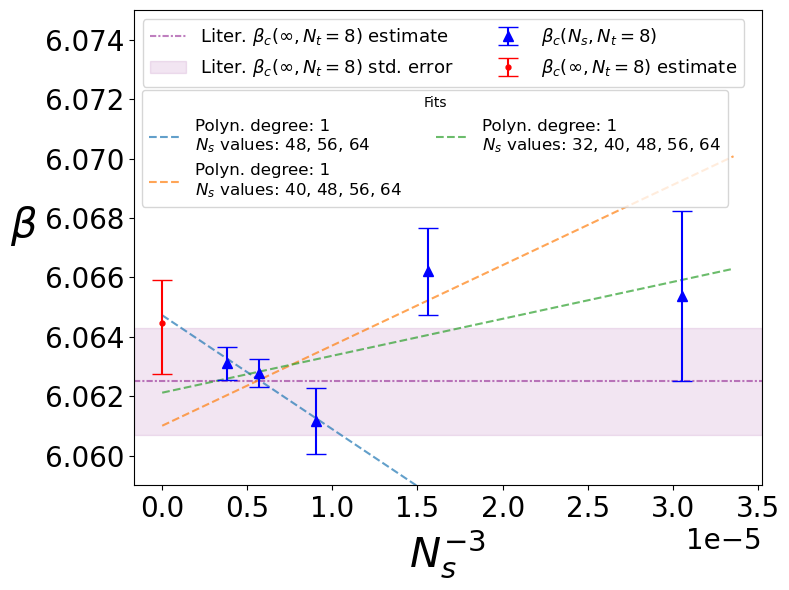

In [49]:
plt.figure(figsize=(8, 6))

plt.axhline(literature_beta, color="purple", linestyle=(0, (3, 1, 1, 1)), alpha=0.5, label=r"Liter. $\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ estimate")
plt.axhspan(lit_beta_min, lit_beta_max, color="purple", alpha=0.1, label=r"Liter. $\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ std. error")


# Plot each polynomial fit
for j,row in enumerate(df.rows(named=True)):
    intercept = row["beta_c"]
    coefficients = row["coefficients"]
    deg = row["k_max"]
    
    # Generate smooth x values for plotting the curve
    x_plot = np.linspace(0, max(x)*1.1, 300)
    
    # Manually compute polynomial: intercept + c1*x + c2*x² + ...
    y_plot = intercept + sum(
        coef * (x_plot ** (i + 1)) 
        for i, coef in enumerate(coefficients)
    )
    
    rangemin = list(map(int, row['range_min'].strip("[]").split()))[1]
    rangemax = list(map(int, row['range_max'].strip("[]").split()))[1]
    Ns_range = np.arange(rangemin, rangemax+1, Ls[0,0])
    Ns_range_str = ", ".join(str(l) for l in Ns_range)
    
    # Label the fit
    label = f"Polyn. degree: {deg}\n$N_s$ values: {Ns_range_str}"
    plt.plot(x_plot, y_plot, "--", label=label, alpha=0.7)
    
    
x = 1/vol
y = pseudo_bcs_b0
plt.errorbar(x, y, yerr=yerr_b0, fmt="^", label=r"$\beta_c ( N_s, N_t =$"+f"{Ls[0,0]}"+r"$)$", capsize=7, color="blue", markersize=7)
plt.errorbar(0, median_val, yerr=[[error_lower], [error_upper]], fmt=".", label=r"$\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ estimate", capsize=7, color="red", markersize=7)

plt.xlabel(r"$N_{s}^{-3}$",fontsize=30)
plt.ylabel(r"$\beta$", fontsize=30,rotation=0,labelpad=15)
plt.ylim([6.059, 6.075])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = plt.gca()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.get_offset_text().set_fontsize(20)
handles, labels = ax.get_legend_handles_labels()

# split handles/labels into "fits" vs "others"
is_fit = [lab.startswith("Polyn.") for lab in labels]
fit_handles  = [h for h,f in zip(handles,is_fit) if f]
fit_labels   = [l for l,f in zip(labels,is_fit) if f]
other_handles = [h for h,f in zip(handles,is_fit) if not f]
other_labels  = [l for l,f in zip(labels,is_fit) if not f]

leg1 = ax.legend(
    other_handles, other_labels,
    loc='upper left',
    frameon=True,
    ncol=2,
    fontsize=13
)
leg2 = ax.legend(
    fit_handles, fit_labels,
    loc='upper left',
    bbox_to_anchor=(0.0, 0.85),
    frameon=True,
    title="Fits",
    ncol=2,
    fontsize=12
)
ax.add_artist(leg1)

plt.tight_layout()
plt.savefig(f"../reports/Nt={Ls[0,0]}/figures/fits_rho0.pdf", format="pdf",bbox_inches='tight',pad_inches=0.025)
plt.show()

$\rho_1$

In [50]:
# Define the range of Ls values to be used in FSS
range_ = [[2, 3, 4], [1, 2, 3, 4], [0, 1, 2, 3, 4]]

# When computing results, filter out any models where fss returns None
results = []
for type, ps_bc, ps_bc_var in [("rho_b1", pseudo_bcs_b1, pseudo_bcs_b1_bs.T)]:
    for i in range(len(range_)):
        for d in range(1, len(range_[i]) - 1):
            model = fss(type, range_[i], d, ps_bc, ps_bc_var)
            if model is not None:
                results.append(model)

Rejecting fit; found internal extremum at [7.71818615e-06]
Rejecting fit; found internal extremum at [2.48697180e-05 7.16436655e-06]


In [51]:
df = pl.DataFrame(results)
df.columns = [
    "observable",
    "range_min",
    "range_max",
    "k_max",
    "chi2",
    "aic_unnorm",
    "beta_c",
    "coefficients",
    "beta_c_err",
    "str_chi2",
    "str_aic",
    "beta_c_NIST",
]

In [52]:
df

observable,range_min,range_max,k_max,chi2,aic_unnorm,beta_c,coefficients,beta_c_err,str_chi2,str_aic,beta_c_NIST
str,str,str,i64,f64,f64,f64,list[f64],f64,str,str,str
"""rho_b1""","""[ 8 48 48 48]""","""[ 8 64 64 64]""",1,0.841125,0.398295,6.061955,[81.458576],0.000615,"""0.841""","""0.398""","""6.0620(6)"""
"""rho_b1""","""[ 8 40 40 40]""","""[ 8 64 64 64]""",1,4.571498,0.101698,6.063115,[-122.404126],0.000326,"""4.571""","""0.102""","""6.0631(3)"""
"""rho_b1""","""[ 8 32 32 32]""","""[ 8 64 64 64]""",1,4.061324,0.216392,6.062836,[-85.806308],0.0004,"""4.061""","""0.216""","""6.0628(4)"""
"""rho_b1""","""[ 8 32 32 32]""","""[ 8 64 64 64]""",2,4.510897,0.063581,6.063099,"[-133.795288, 1.3719e6]",0.00046,"""4.511""","""0.064""","""6.0631(5)"""


In [53]:
# Extract AIC, intercepts, and errors
weight_unnorms_b1 = np.array([model[5] for model in results])  # Assuming AIC is the 6th element
beta_c_values_b1 = np.array([model[6] for model in results])  # Intercept
beta_c_errs_b1 = np.array([model[8] for model in results])  # Intercept error

# Compute model weights (pr(M|D))
weights_b1 = weight_unnorms_b1 / np.sum(weight_unnorms_b1)
weights_b1

array([0.510657  , 0.1303876 , 0.27743834, 0.08151706])

In [54]:
# Define a search interval that should comfortably include the distribution.
x_min_search = np.min(beta_c_values_b1) - 5 * np.max(beta_c_errs_b1)
x_max_search = np.max(beta_c_values_b1) + 5 * np.max(beta_c_errs_b1)

# Compute the quantiles for the median and the 68% interval.
lower_val = find_quantile(0.16, weights_b1, beta_c_values_b1, beta_c_errs_b1, x_min_search, x_max_search)
median_val = find_quantile(0.5, weights_b1, beta_c_values_b1, beta_c_errs_b1, x_min_search, x_max_search)
upper_val = find_quantile(0.84, weights_b1, beta_c_values_b1, beta_c_errs_b1, x_min_search, x_max_search)

# Compute asymmetric errors (distance from the median to the lower and upper bounds)
error_lower = median_val - lower_val
error_upper = upper_val - median_val

In [55]:
error_lower, median_val, error_upper

(0.0008828852763826944, 6.062537242987983, 0.0006339318004791039)

In [56]:
latex_str = format_asymmetric_error(lower_val, median_val, upper_val)
print(latex_str)

$6.0625^{+0.0006}_{-0.0009}$


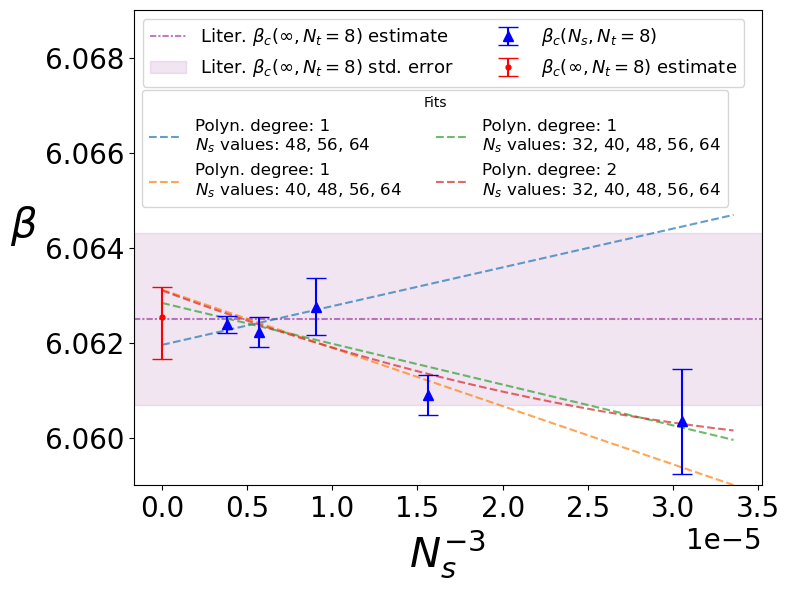

In [57]:
plt.figure(figsize=(8, 6))

plt.axhline(literature_beta, color="purple", linestyle=(0, (3, 1, 1, 1)), alpha=0.5, label=r"Liter. $\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ estimate")
plt.axhspan(lit_beta_min, lit_beta_max, color="purple", alpha=0.1, label=r"Liter. $\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ std. error")


# Plot each polynomial fit
for j,row in enumerate(df.rows(named=True)):
    intercept = row["beta_c"]
    coefficients = row["coefficients"]
    deg = row["k_max"]
    
    # Generate smooth x values for plotting the curve
    x_plot = np.linspace(0, max(x)*1.1, 300)
    
    # Manually compute polynomial: intercept + c1*x + c2*x² + ...
    y_plot = intercept + sum(
        coef * (x_plot ** (i + 1)) 
        for i, coef in enumerate(coefficients)
    )
    
    rangemin = list(map(int, row['range_min'].strip("[]").split()))[1]
    rangemax = list(map(int, row['range_max'].strip("[]").split()))[1]
    Ns_range = np.arange(rangemin, rangemax+1, Ls[0,0])
    Ns_range_str = ", ".join(str(l) for l in Ns_range)
    
    # Label the fit
    label = f"Polyn. degree: {deg}\n$N_s$ values: {Ns_range_str}"
    plt.plot(x_plot, y_plot, "--", label=label, alpha=0.7)
    
    
x = 1/vol
y = pseudo_bcs_b1
plt.errorbar(x, y, yerr=yerr_b1, fmt="^", label=r"$\beta_c ( N_s, N_t =$"+f"{Ls[0,0]}"+r"$)$", capsize=7, color="blue", markersize=7)
plt.errorbar(0, median_val, yerr=[[error_lower], [error_upper]], fmt=".", label=r"$\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ estimate", capsize=7, color="red", markersize=7)

plt.xlabel(r"$N_{s}^{-3}$",fontsize=30)
plt.ylabel(r"$\beta$",fontsize=30,rotation=0,labelpad=15)
plt.ylim([6.0590, 6.0690])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = plt.gca()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.get_offset_text().set_fontsize(20)
handles, labels = ax.get_legend_handles_labels()

# split handles/labels into "fits" vs "others"
is_fit = [lab.startswith("Polyn.") for lab in labels]
fit_handles  = [h for h,f in zip(handles,is_fit) if f]
fit_labels   = [l for l,f in zip(labels,is_fit) if f]
other_handles = [h for h,f in zip(handles,is_fit) if not f]
other_labels  = [l for l,f in zip(labels,is_fit) if not f]

leg1 = ax.legend(
    other_handles, other_labels,
    loc='upper left',
    frameon=True,
    ncol=2,
    fontsize=13
)
leg2 = ax.legend(
    fit_handles, fit_labels,
    loc='upper left',
    bbox_to_anchor=(0.0, 0.85),
    frameon=True,
    title="Fits",
    ncol=2,
    fontsize=12
)
ax.add_artist(leg1)

plt.tight_layout()
plt.savefig(f"../reports/Nt={Ls[0,0]}/figures/fits_rho1.pdf",format="pdf",bbox_inches='tight',pad_inches=0.025)
plt.show()

$\lambda$

In [58]:
# Define the range of Ls values to be used in FSS
range_ = [[2, 3, 4], [1, 2, 3, 4], [0, 1, 2, 3, 4]]

# When computing results, filter out any models where fss returns None
results = []
for type, ps_bc, ps_bc_var in [("r01", pseudo_bcs_r01, pseudo_bcs_r01_bs.T)]:
    for i in range(len(range_)):
        for d in range(1, len(range_[i]) - 1):
            model = fss(type, range_[i], d, ps_bc, ps_bc_var)
            if model is not None:
                results.append(model)

Rejecting fit; found internal extremum at [1.11646702e-05]
Rejecting fit; found internal extremum at [1.39338628e-05]
Rejecting fit; found internal extremum at [3.03507441e-05 1.08943512e-05]


In [59]:
df = pl.DataFrame(results)
df.columns = [
    "observable",
    "range_min",
    "range_max",
    "k_max",
    "chi2",
    "aic_unnorm",
    "beta_c",
    "coefficients",
    "beta_c_err",
    "str_chi2",
    "str_aic",
    "beta_c_NIST",
]

In [60]:
df

observable,range_min,range_max,k_max,chi2,aic_unnorm,beta_c,coefficients,beta_c_err,str_chi2,str_aic,beta_c_NIST
str,str,str,i64,f64,f64,f64,list[f64],f64,str,str,str
"""r01""","""[ 8 48 48 48]""","""[ 8 64 64 64]""",1,0.792017,0.408196,6.061734,[189.41199],0.000922,"""0.792""","""0.408""","""6.0617(9)"""
"""r01""","""[ 8 40 40 40]""","""[ 8 64 64 64]""",1,1.431904,0.488727,6.062556,[44.780965],0.000658,"""1.432""","""0.489""","""6.0626(7)"""
"""r01""","""[ 8 32 32 32]""","""[ 8 64 64 64]""",1,3.824035,0.243651,6.063247,[-45.734901],0.000556,"""3.824""","""0.244""","""6.0632(6)"""


In [61]:
# Extract AIC, intercepts, and errors
weight_unnorms_b1 = np.array([model[5] for model in results])  # Assuming AIC is the 6th element
beta_c_values_b1 = np.array([model[6] for model in results])  # Intercept
beta_c_errs_b1 = np.array([model[8] for model in results])  # Intercept error

# Compute model weights (pr(M|D))
weights_b1 = weight_unnorms_b1 / np.sum(weight_unnorms_b1)
weights_b1

array([0.35788641, 0.42849197, 0.21362161])

In [62]:
# Define a search interval that should comfortably include the distribution.
x_min_search = np.min(beta_c_values_b1) - 5 * np.max(beta_c_errs_b1)
x_max_search = np.max(beta_c_values_b1) + 5 * np.max(beta_c_errs_b1)

# Compute the quantiles for the median and the 68% interval.
lower_val = find_quantile(0.16, weights_b1, beta_c_values_b1, beta_c_errs_b1, x_min_search, x_max_search)
median_val = find_quantile(0.5, weights_b1, beta_c_values_b1, beta_c_errs_b1, x_min_search, x_max_search)
upper_val = find_quantile(0.84, weights_b1, beta_c_values_b1, beta_c_errs_b1, x_min_search, x_max_search)

# Compute asymmetric errors (distance from the median to the lower and upper bounds)
error_lower = median_val - lower_val
error_upper = upper_val - median_val

In [63]:
error_lower, median_val, error_upper

(0.0010204172953551804, 6.062490703086073, 0.0008404517808662249)

In [64]:
latex_str = format_asymmetric_error(lower_val, median_val, upper_val)
print(latex_str)

$6.0625^{+0.0008}_{-0.0010}$


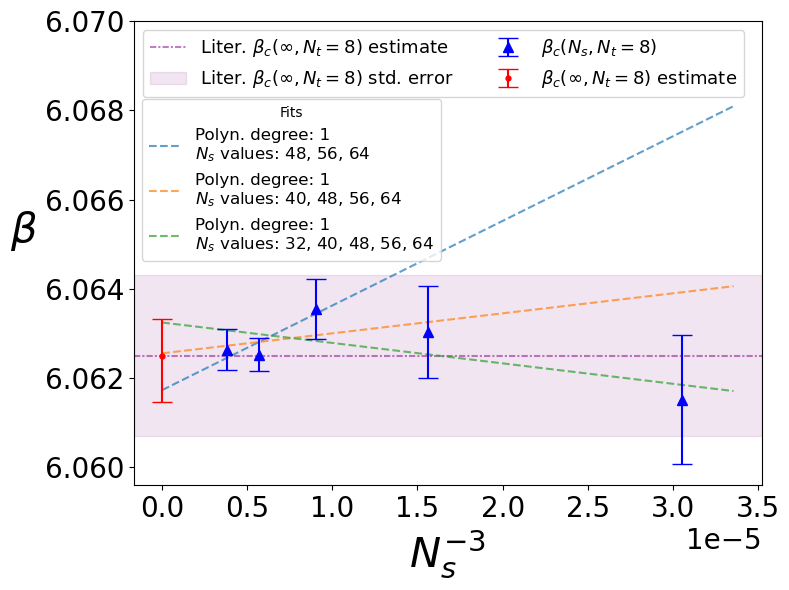

In [66]:
plt.figure(figsize=(8, 6))

plt.axhline(literature_beta, color="purple", linestyle=(0, (3, 1, 1, 1)), alpha=0.5, label=r"Liter. $\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ estimate")
plt.axhspan(lit_beta_min, lit_beta_max, color="purple", alpha=0.1, label=r"Liter. $\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ std. error")

# Plot each polynomial fit
for j,row in enumerate(df.rows(named=True)):
    intercept = row["beta_c"]
    coefficients = row["coefficients"]
    deg = row["k_max"]
    
    # Generate smooth x values for plotting the curve
    x_plot = np.linspace(0, max(x)*1.1, 300)
    
    # Manually compute polynomial: intercept + c1*x + c2*x² + ...
    y_plot = intercept + sum(
        coef * (x_plot ** (i + 1)) 
        for i, coef in enumerate(coefficients)
    )
    
    rangemin = list(map(int, row['range_min'].strip("[]").split()))[1]
    rangemax = list(map(int, row['range_max'].strip("[]").split()))[1]
    Ns_range = np.arange(rangemin, rangemax+1, Ls[0,0])
    Ns_range_str = ", ".join(str(l) for l in Ns_range)
    
    # Label the fit
    label = f"Polyn. degree: {deg}\n$N_s$ values: {Ns_range_str}"
    plt.plot(x_plot, y_plot, "--", label=label, alpha=0.7)
    
    
x = 1/vol
y = pseudo_bcs_r01
plt.errorbar(x, y, yerr=yerr_r01, fmt="^", label=r"$\beta_c ( N_s, N_t =$"+f"{Ls[0,0]}"+r"$)$", capsize=7, color="blue", markersize=7)
plt.errorbar(0, median_val, yerr=[[error_lower], [error_upper]], fmt=".", label=r"$\beta_c (\infty, N_t =$"+f"{Ls[0,0]}"+r"$)$ estimate", capsize=7, color="red", markersize=7)

plt.xlabel(r"$N_{s}^{-3}$",fontsize=30)
plt.ylabel(r"$\beta$", fontsize=30,rotation=0,labelpad=15)
plt.ylim([6.0596, 6.0700])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = plt.gca()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.get_offset_text().set_fontsize(20)
handles, labels = ax.get_legend_handles_labels()

# split handles/labels into "fits" vs "others"
is_fit = [lab.startswith("Polyn.") for lab in labels]
fit_handles  = [h for h,f in zip(handles,is_fit) if f]
fit_labels   = [l for l,f in zip(labels,is_fit) if f]
other_handles = [h for h,f in zip(handles,is_fit) if not f]
other_labels  = [l for l,f in zip(labels,is_fit) if not f]

leg1 = ax.legend(
    other_handles, other_labels,
    loc='upper left',
    frameon=True,
    ncol=2,
    fontsize=13
)
leg2 = ax.legend(
    fit_handles, fit_labels,
    loc='upper left',
    bbox_to_anchor=(0.0, 0.85),
    frameon=True,
    title="Fits",
    ncol=1,
    fontsize=12
)
ax.add_artist(leg1)

plt.tight_layout()
plt.savefig(f"../reports/Nt={Ls[0,0]}/figures/fits_r01.pdf",format="pdf",bbox_inches='tight',pad_inches=0.025)
plt.show()